# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import json
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize


# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/gabriel/.pyenv/versions/3.6.15/envs/maskrcnn_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gabriel/.pyenv/versions/3.6.15/envs/maskrcnn_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gabriel/.pyenv/versions/3.6.15/envs/maskrcnn_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

## Configurations

In [14]:
class CustomConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "custom"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 25  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = None

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  None
IMAGE_META_SIZE                38
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [None None 3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

## Notebook Preferences

In [2]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [3]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir_, subset, subset_type):
        """Load a subset of the custom dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        dataset_dir = os.path.join(dataset_dir_,subset_type)
        annotation_path = os.path.join(dataset_dir, "annotations.json")
        with open(annotation_path) as f:
            annotations = json.load(f)

        for annotation in annotations['categories']:
            self.add_class("building", annotation['id'], annotation['name'])

        for annotation in annotations['images']:
            image_path = os.path.join(dataset_dir, annotation['file_name'])
            self.add_image(
                "building",
                image_id=annotation['id'],
                path=image_path,
                width=annotation['width'],
                height=annotation['height'],
                annotations=[ann for ann in annotations['annotations'] if ann['image_id'] == annotation['id']]
            )
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        
        masks = np.zeros([image_info["height"], image_info["width"], len(annotations)], dtype=np.uint8)
        class_ids = np.zeros((len(annotations),), dtype=np.int32)
        
        for i, annotation in enumerate(annotations):
            class_id = annotation['category_id']
            mask = self.annToMask(annotation, image_info["height"], image_info["width"])
            masks[:, :, i] = mask
            class_ids[i] = class_id
        
        return masks.astype(np.bool_), class_ids.astype(np.int32)

    def annToMask(self, ann, height, width):
        """Convert annotation to mask.
        ann: Annotation dictionary
        height, width: Image height and width
        Returns:
        mask: Binary mask (numpy 2D array)
        """
        mask = np.zeros((height, width), dtype=np.uint8)
        if 'segmentation' in ann:
            for seg in ann['segmentation']:
                if type(seg) == list:
                    poly = np.array(seg).reshape((len(seg) // 2, 2))
                    cv2.fillPoly(mask, [poly], 1)
        return mask
    
    def load_dataset(self, dataset_dir, subset, subset_type):
        """Load a subset of the dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        subset_type: Type of subset: "BLD-AR-coco" or "BLD-ST-coco"
        """
        
        # Define data locations
        coco_dir = os.path.join(dataset_dir, subset_type)
        #image_dir = os.path.join(coco_dir, "JPEGImages")
        annotation_file = os.path.join(coco_dir, "annotations.json")

        # Load annotations
        with open(annotation_file) as f:
            annotations = json.load(f)

        # Add classes
        for category in annotations['categories']:
            self.add_class("building", category['id'], category['name'])
        
        # Add images and annotations
        for image in annotations['images']:
            self.add_image(
                "building",
                image_id=image['id'],
                path=os.path.join(coco_dir, image['file_name']),
                width=image['width'],
                height=image['height'],
                annotations=[a for a in annotations['annotations'] if a['image_id'] == image['id']]
            )

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array."""
        info = self.image_info[image_id]
        return skimage.io.imread(info['path'])

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        annotations = info['annotations']
        
        masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            segmentation = annotation['segmentation'][0]
            mask = np.zeros((info['height'], info['width']), dtype=np.uint8)
            rr, cc = skimage.draw.polygon(segmentation[1::2], segmentation[0::2])
            mask[rr, cc] = 1
            masks.append(mask)
            class_ids.append(class_id)
        
        if masks:
            masks = np.stack(masks, axis=-1)
        else:
            masks = np.empty((info['height'], info['width'], 0), dtype=np.uint8)
        
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return masks, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        return info["path"]
    


In [5]:
def print_dataset_info(dataset):
    print("Class Info:")
    for i, info in enumerate(dataset.class_info):
        print(f"  ID {i}: {info}")
    print("Image Info:")
    for i, info in enumerate(dataset.image_info[:5]):  # Only show first 5 images for brevity
        print(f"  ID {i}: {info}")

In [6]:
# Entrenamiento
dataset_dir = "paper-struct-arq2bim/Datasets/BLD-ST.AR/Coco"

# Training dataset for AR
dataset_train_ar = CustomDataset()
dataset_train_ar.load_custom(dataset_dir, "train", "BLD-AR-coco")
dataset_train_ar.prepare()

# Training dataset for ST
dataset_train_st = CustomDataset()
dataset_train_st.load_custom(dataset_dir, "train", "BLD-ST-coco")
dataset_train_st.prepare()

# Validation dataset for AR
dataset_val_ar = CustomDataset()
dataset_val_ar.load_custom(dataset_dir, "val", "BLD-AR-coco")
dataset_val_ar.prepare()

# Validation dataset for ST
dataset_val_st = CustomDataset()
dataset_val_st.load_custom(dataset_dir, "val", "BLD-ST-coco")
dataset_val_st.prepare()

In [7]:
# Verificar información del dataset
print("Training AR Dataset:")
print_dataset_info(dataset_train_ar)

print("Training ST Dataset:")
print_dataset_info(dataset_train_st)

Training AR Dataset:
Class Info:
  ID 0: {'source': '', 'id': 0, 'name': 'BG'}
  ID 1: {'source': 'building', 'id': 0, 'name': '_background_'}
  ID 2: {'source': 'building', 'id': 1, 'name': 'demolish'}
  ID 3: {'source': 'building', 'id': 2, 'name': 'wall'}
  ID 4: {'source': 'building', 'id': 3, 'name': 'column'}
  ID 5: {'source': 'building', 'id': 4, 'name': 'window'}
  ID 6: {'source': 'building', 'id': 5, 'name': 'door'}
  ID 7: {'source': 'building', 'id': 6, 'name': 'railing'}
  ID 8: {'source': 'building', 'id': 7, 'name': 'stair'}
  ID 9: {'source': 'building', 'id': 8, 'name': 'void'}
  ID 10: {'source': 'building', 'id': 9, 'name': 'pocket_door'}
  ID 11: {'source': 'building', 'id': 10, 'name': 'cwall'}
  ID 12: {'source': 'building', 'id': 11, 'name': 'ramp'}
  ID 13: {'source': 'building', 'id': 12, 'name': 'parapet_railing'}
  ID 14: {'source': 'building', 'id': 13, 'name': 'elevator'}
  ID 15: {'source': 'building', 'id': 14, 'name': 'elevator_door'}
  ID 16: {'source'

In [8]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Desactivar el límite de tamaño de imagen


Displaying image with ID: 28
Class names: ['BG', '_background_', 'demolish', 'wall', 'column', 'window', 'door', 'railing', 'stair', 'void', 'pocket_door', 'cwall', 'ramp', 'parapet_railing', 'elevator', 'elevator_door', 'partition_wall', 'sliding_door', 'parapet_wall', 'gutter', 'metal_roof', 'finial', 'horizontal_void', 'car_elevator', 'gate', 'roof_flashing_metal', 'vent_cap']
Mask IDs for image 28: [ 8  5  2  2  2  2  2  2  4  4  5  5  9  5  5  4  5  4  4  4  5  5  2  2
  2  4  2  9  7  6 12  6  2  2  4  2  4  2  2 16 16 16  2  2  5  2  4  2
  2  2  2  9  2  2  4  5]


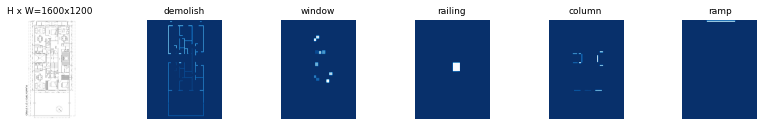

Displaying image with ID: 51
Class names: ['BG', '_background_', 'demolish', 'wall', 'column', 'window', 'door', 'railing', 'stair', 'void', 'pocket_door', 'cwall', 'ramp', 'parapet_railing', 'elevator', 'elevator_door', 'partition_wall', 'sliding_door', 'parapet_wall', 'gutter', 'metal_roof', 'finial', 'horizontal_void', 'car_elevator', 'gate', 'roof_flashing_metal', 'vent_cap']
Mask IDs for image 51: [ 3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  2  2  2  2  2  2  2  2  2  2  2  2  5  2  2  7  8  8  2  2  7 11  2  5
  5]


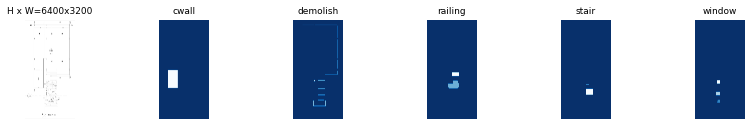

Displaying image with ID: 46
Class names: ['BG', '_background_', 'demolish', 'wall', 'column', 'window', 'door', 'railing', 'stair', 'void', 'pocket_door', 'cwall', 'ramp', 'parapet_railing', 'elevator', 'elevator_door', 'partition_wall', 'sliding_door', 'parapet_wall', 'gutter', 'metal_roof', 'finial', 'horizontal_void', 'car_elevator', 'gate', 'roof_flashing_metal', 'vent_cap']
Mask IDs for image 46: [17  3  2  3  3  3  3  3  3  3  2  5  4  5  2  2  2  5  5  2  4 17 17  2
  8 17  8  2  2  6  2  7  6]


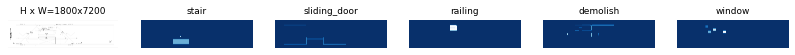

Displaying image with ID: 41
Class names: ['BG', '_background_', 'demolish', 'wall', 'column', 'window', 'door', 'railing', 'stair', 'void', 'pocket_door', 'cwall', 'ramp', 'parapet_railing', 'elevator', 'elevator_door', 'partition_wall', 'sliding_door', 'parapet_wall', 'gutter', 'metal_roof', 'finial', 'horizontal_void', 'car_elevator', 'gate', 'roof_flashing_metal', 'vent_cap']
Mask IDs for image 41: [ 3  3  3  3  3  3  3  3  3  3  3  2  5  7  8 13 11  3  3  3  3  3  3  3
  2  2  3  2  3  3  2  2  2  2  2  5  4  4  2  4  4  2  2  2 14  2  5  5
  2  2  5  2  5  2  2  4  4  4  2  2  2  2]


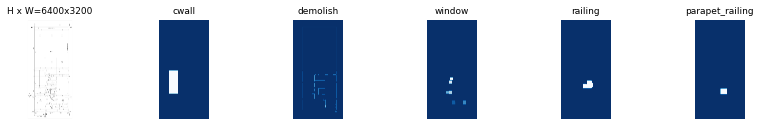

In [9]:
image_ids = np.random.choice(dataset_train_ar.image_ids, 4)
for image_id in image_ids:(8, 16, 32, 64, 128)
    print(f"Displaying image with ID: {image_id}")
    image = dataset_train_ar.load_image(image_id)
    mask, class_ids = dataset_train_ar.load_mask(image_id)
    
    print(f"Class names: {dataset_train_ar.class_names}")
    dataset_train_ar.class_names
    print(f"Mask IDs for image {image_id}: {class_ids}")
    
    visualize.display_top_masks(image, mask, class_ids, dataset_train_ar.class_names, limit=5)

## Create Model

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

Loading weights from  /home/gabriel/Proyectos/Tesis/maskrcc/mask_rcnn_coco.h5


original_image           shape: (128, 128, 3)         min:    8.00000  max:  230.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   14.00000  max:   66.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool


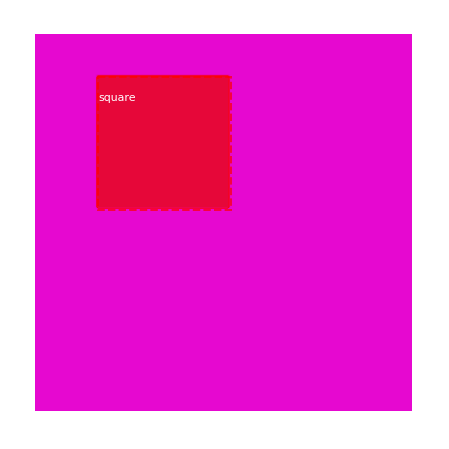

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   71.00000  max:  204.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -32.90000  max:   80.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


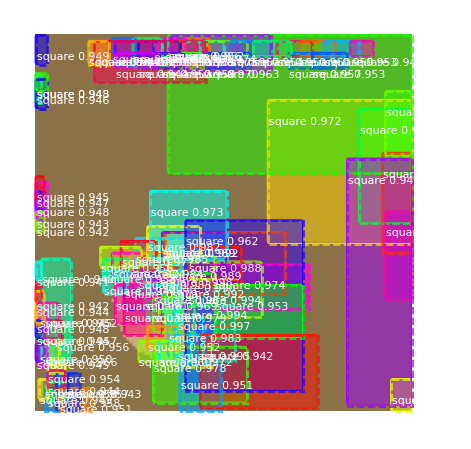

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
